In [2]:
############################################################
# COMPREHENSIVE REVISED CODE
############################################################

import pandas as pd
import numpy as np
import gdown

############################################################
# 1) DATA LOADING
############################################################
file_urls = {
    'application_train': 'https://drive.google.com/uc?id=1-gipg2ewVE-UR6GWbo593vnJWXkjfPsz',
}
for key, url in file_urls.items():
    gdown.download(url, f'{key}.csv', quiet=False)

df_full = pd.read_csv('application_train.csv')
print("Original Data shape (full):", df_full.shape)

Downloading...
From (original): https://drive.google.com/uc?id=1-gipg2ewVE-UR6GWbo593vnJWXkjfPsz
From (redirected): https://drive.google.com/uc?id=1-gipg2ewVE-UR6GWbo593vnJWXkjfPsz&confirm=t&uuid=c7658835-3601-4840-8119-f6220b31da75
To: /content/application_train.csv
100%|██████████| 166M/166M [00:02<00:00, 63.5MB/s]


Original Data shape (full): (307511, 122)


In [3]:
############################################################
# Import Libraries
############################################################
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import shap

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.metrics import (roc_auc_score, roc_curve, f1_score,
                             confusion_matrix, precision_score, recall_score)

# Machine Learning Models
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

# SMOTE (for non-tree models)
!pip install imblearn --quiet
from imblearn.over_sampling import SMOTE

############################################################
# 1) Define Subset Columns vs. Other Columns
############################################################
subset_cols = [
    'TARGET',
    'NAME_CONTRACT_TYPE',
    'FLAG_OWN_CAR',
    'DAYS_EMPLOYED',
    'REGION_POPULATION_RELATIVE',
    'EXT_SOURCE_3',
    # Will drop these after ratio creation:
    'AMT_CREDIT',
    'AMT_GOODS_PRICE',
    'AMT_ANNUITY',
    'AMT_INCOME_TOTAL',
    'DAYS_BIRTH'
]

all_cols = set(df_full.columns)
used_cols = set(subset_cols)
other_cols = list(all_cols - used_cols)

print("\nNumber of 'other' columns:", len(other_cols))

############################################################
# 2) Subset DataFrame & Create Ratio Features
############################################################
df_subset = df_full[subset_cols].copy()
print("df_subset shape:", df_subset.shape)

# Fill and clean up
df_subset['EXT_SOURCE_3'].fillna(df_subset['EXT_SOURCE_3'].mean(), inplace=True)
df_subset.replace([np.inf, -np.inf], np.nan, inplace=True)
df_subset.dropna(subset=['TARGET'], inplace=True)

# Create ratio features
df_subset['credit_goods_price_ratio'] = df_subset['AMT_CREDIT'] / df_subset['AMT_GOODS_PRICE']
df_subset['annuity_to_income_ratio'] = df_subset['AMT_ANNUITY'] / (df_subset['AMT_INCOME_TOTAL'] + 1e-6)
df_subset['AGE'] = -df_subset['DAYS_BIRTH'] / 365.0
df_subset['credit_annuity_ratio'] = df_subset['AMT_CREDIT'] / (df_subset['AMT_ANNUITY'] + 1e-6)

# Drop original columns no longer needed
df_subset.drop(columns=[
    'AMT_CREDIT','AMT_GOODS_PRICE','AMT_ANNUITY','AMT_INCOME_TOTAL','DAYS_BIRTH'
], inplace=True, errors='ignore')
print("\nColumns in df_subset after ratio creation:\n", df_subset.columns)

############################################################
# 3) Build "others" & Clean
############################################################
df_others = df_full.loc[df_subset.index, other_cols].copy()
if 'TARGET' in df_others.columns:
    df_others.drop(columns=['TARGET'], inplace=True)
df_others.replace([np.inf, -np.inf], np.nan, inplace=True)
print("\nShape of df_others before encoding:", df_others.shape)

############################################################
# 4) One-Hot Encode
############################################################
# Separate target from features
y = df_subset['TARGET']
df_subset_features = df_subset.drop(columns=['TARGET'])

subset_cat_cols = ['NAME_CONTRACT_TYPE','FLAG_OWN_CAR']
df_subset_enc = pd.get_dummies(df_subset_features, columns=subset_cat_cols, drop_first=True)
df_others_enc = pd.get_dummies(df_others, drop_first=True)

# Align the columns
df_subset_enc, df_others_enc = df_subset_enc.align(df_others_enc, join='outer', axis=1, fill_value=0)
df_subset_enc.fillna(0, inplace=True)
df_others_enc.fillna(0, inplace=True)



Number of 'other' columns: 111
df_subset shape: (307511, 11)

Columns in df_subset after ratio creation:
 Index(['TARGET', 'NAME_CONTRACT_TYPE', 'FLAG_OWN_CAR', 'DAYS_EMPLOYED',
       'REGION_POPULATION_RELATIVE', 'EXT_SOURCE_3',
       'credit_goods_price_ratio', 'annuity_to_income_ratio', 'AGE',
       'credit_annuity_ratio'],
      dtype='object')


<ipython-input-3-228f39a2625c>:60: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_subset['EXT_SOURCE_3'].fillna(df_subset['EXT_SOURCE_3'].mean(), inplace=True)



Shape of df_others before encoding: (307511, 111)



Train size: 184506, Val size: 61502, Test size: 61503

Explained variance ratio (first 10 comps): [0.11218663 0.02385773 0.01823352 0.01507283 0.01395601 0.01357579
 0.01231393 0.01153363 0.0111727  0.01031425]

Final shapes after combining subset+PCA for each split:
Train: (184506, 238), Val: (61502, 238), Test: (61503, 238)

After SMOTE, Train shape (for LR, DT, NN): (339222, 238),  Pos class ratio = 0.5000
[LOGISTIC] param={'C': 0.01}, val AUC=0.7145
[LOGISTIC] param={'C': 0.1}, val AUC=0.7144
[LOGISTIC] param={'C': 1.0}, val AUC=0.7144
[LOGISTIC] param={'C': 10.0}, val AUC=0.7144

[LOGISTIC] Best param={'C': 0.01}, val AUC=0.7145
[DEC TREE] param={'max_depth': 3, 'min_samples_leaf': 5}, val AUC=0.6478
[DEC TREE] param={'max_depth': 5, 'min_samples_leaf': 5}, val AUC=0.6395
[DEC TREE] param={'max_depth': 10, 'min_samples_leaf': 10}, val AUC=0.6348
[DEC TREE] param={'max_depth': 15, 'min_samples_leaf': 10}, val AUC=0.6123

[DEC TREE] Best param={'max_depth': 3, 'min_samples_leaf': 5

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [00:22:51] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[XGB Revised] param={'n_estimators': 200, 'max_depth': 3, 'learning_rate': 0.05, 'subsample': 0.8, 'colsample_bytree': 0.8, 'gamma': 1, 'reg_lambda': 1, 'scale_pos_weight': 11.38710976837865}, val AUC=0.7287
early_stopping_rounds not supported; fitting without it.


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [00:23:09] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[XGB Revised] param={'n_estimators': 200, 'max_depth': 3, 'learning_rate': 0.1, 'subsample': 0.7, 'colsample_bytree': 0.7, 'gamma': 0.5, 'reg_lambda': 1, 'scale_pos_weight': 11.38710976837865}, val AUC=0.7335
early_stopping_rounds not supported; fitting without it.


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [00:23:28] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


[XGB Revised] param={'n_estimators': 300, 'max_depth': 2, 'learning_rate': 0.05, 'subsample': 0.8, 'colsample_bytree': 0.8, 'gamma': 1, 'reg_lambda': 1, 'scale_pos_weight': 11.38710976837865}, val AUC=0.7274

[XGBoost Revised] Best param={'n_estimators': 200, 'max_depth': 3, 'learning_rate': 0.1, 'subsample': 0.7, 'colsample_bytree': 0.7, 'gamma': 0.5, 'reg_lambda': 1, 'scale_pos_weight': 11.38710976837865}, val AUC=0.7335
early_stopping_rounds not supported; fitting without it.


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [00:23:50] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Epoch 1/20
2651/2651 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - AUC: 0.7167 - loss: 0.6168 - val_AUC: 0.7131 - val_loss: 0.5946
Epoch 2/20
2651/2651 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - AUC: 0.7456 - loss: 0.5951 - val_AUC: 0.7111 - val_loss: 0.5923
Epoch 3/20
2651/2651 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - AUC: 0.7502 - loss: 0.5911 - val_AUC: 0.7091 - val_loss: 0.6030
Epoch 4/20
2651/2651 ━━━━━━━━━━━━━━━━━━━━ 11s 3ms/step - AUC: 0.7544 - loss: 0.5873 - val_AUC: 0.7095 - val_loss: 0.5999
Epoch 5/20
2651/2651 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - AUC: 0.7565 - loss: 0.5854 - val_AUC: 0.7085 - val_loss: 0.6154
Epoch 5: early stopping
Restoring model weights from the end of the best epoch: 2.
1922/1922 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step
[NN] config={'units1': 32, 'units2': 32, 'dropout': 0.2}, val AUC=0.7112
Epoch 1/20
2651/2651 ━━━━━━━━━━━━━━━━━━━━ 14s 5ms/step - AUC: 0.7198 - loss: 0.6149 - val_AUC: 0.7142 - val_loss: 0.6041
Epoch 2/20
2651/2651 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - AUC: 0.7467 - loss:

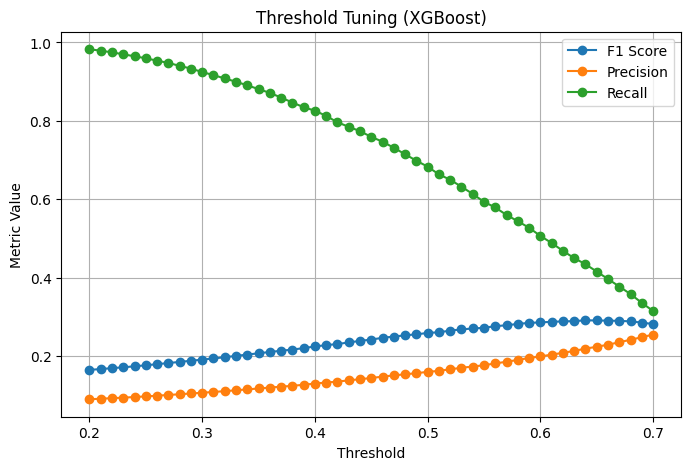


XGBoost Confusion Matrix (Test) with best threshold from validation:
[[48965  7573]
 [ 2809  2156]]
Precision=0.2216, Recall=0.4342, F1=0.2935

=== Confusion Matrices & Derived Metrics (Threshold=0.5) ===

[Logistic]
Confusion Matrix:
[[37803 18735]
 [ 1719  3246]]
TN=37803, FP=18735, FN=1719, TP=3246
Precision=0.1477, Recall=0.6538, F1=0.2409, Specificity=0.6686, FPR=0.3314

[Decision Tree]
Confusion Matrix:
[[36946 19592]
 [ 2146  2819]]
TN=36946, FP=19592, FN=2146, TP=2819
Precision=0.1258, Recall=0.5678, F1=0.2059, Specificity=0.6535, FPR=0.3465

[XGBoost]
Confusion Matrix:
[[38779 17759]
 [ 1675  3290]]
TN=38779, FP=17759, FN=1675, TP=3290
Precision=0.1563, Recall=0.6626, F1=0.2529, Specificity=0.6859, FPR=0.3141

[Neural Network]
Confusion Matrix:
[[36452 20086]
 [ 1688  3277]]
TN=36452, FP=20086, FN=1688, TP=3277
Precision=0.1403, Recall=0.6600, F1=0.2314, Specificity=0.6447, FPR=0.3553


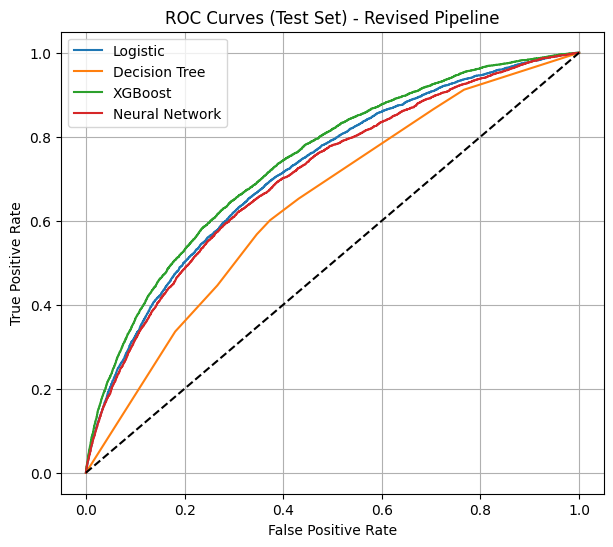

SHAP values computed on sample from train+val data.


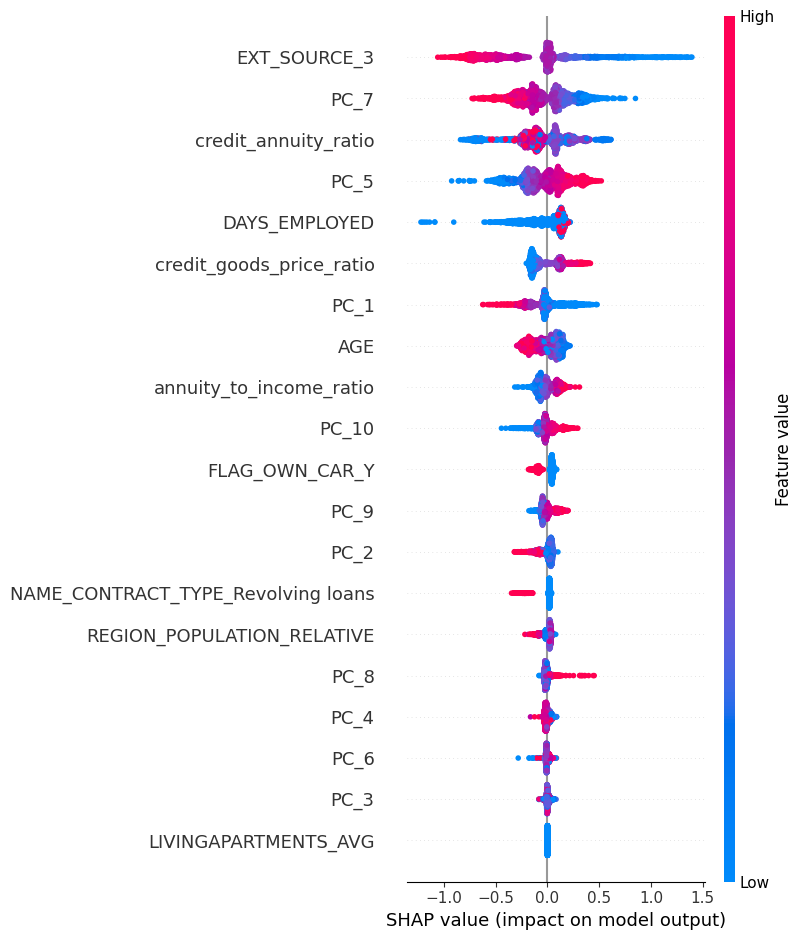

In [4]:

############################################################
# 5) Train/Val/Test Split (60/20/20)
############################################################
all_indices = df_subset_enc.index
X_temp_idx, X_test_idx, y_temp, y_test = train_test_split(
    all_indices, y, test_size=0.2, random_state=42, stratify=y
)
X_train_idx, X_val_idx, y_train, y_val = train_test_split(
    X_temp_idx, y_temp, test_size=0.25, random_state=42, stratify=y_temp
)
print(f"\nTrain size: {len(X_train_idx)}, Val size: {len(X_val_idx)}, Test size: {len(X_test_idx)}")

############################################################
# 6) PCA on "others" for Train only
############################################################
# Split "others" into train/val/test
X_train_others = df_others_enc.loc[X_train_idx]
X_val_others   = df_others_enc.loc[X_val_idx]
X_test_others  = df_others_enc.loc[X_test_idx]

scaler_others = StandardScaler()
X_train_others_scaled = scaler_others.fit_transform(X_train_others)

pca = PCA(n_components=10, random_state=42)
X_train_others_pca = pca.fit_transform(X_train_others_scaled)

X_val_others_scaled  = scaler_others.transform(X_val_others)
X_val_others_pca     = pca.transform(X_val_others_scaled)
X_test_others_scaled = scaler_others.transform(X_test_others)
X_test_others_pca    = pca.transform(X_test_others_scaled)

print(f"\nExplained variance ratio (first 10 comps): {pca.explained_variance_ratio_}")

pca_cols = [f"PC_{i+1}" for i in range(10)]
df_train_others_pca = pd.DataFrame(X_train_others_pca, index=X_train_idx, columns=pca_cols)
df_val_others_pca   = pd.DataFrame(X_val_others_pca,   index=X_val_idx,   columns=pca_cols)
df_test_others_pca  = pd.DataFrame(X_test_others_pca,  index=X_test_idx,  columns=pca_cols)

############################################################
# 7) Combine subset_enc + PCA for each split
############################################################
X_train_subset = df_subset_enc.loc[X_train_idx]
X_val_subset   = df_subset_enc.loc[X_val_idx]
X_test_subset  = df_subset_enc.loc[X_test_idx]

X_train = pd.concat([X_train_subset, df_train_others_pca], axis=1)
X_val   = pd.concat([X_val_subset,   df_val_others_pca],   axis=1)
X_test  = pd.concat([X_test_subset,  df_test_others_pca],  axis=1)

print("\nFinal shapes after combining subset+PCA for each split:")
print(f"Train: {X_train.shape}, Val: {X_val.shape}, Test: {X_test.shape}")

############################################################
# 8) Impute & Scale
############################################################
final_imputer = SimpleImputer(strategy='mean')
final_scaler = StandardScaler()

X_train_imp = final_imputer.fit_transform(X_train)
X_val_imp   = final_imputer.transform(X_val)
X_test_imp  = final_imputer.transform(X_test)

X_train_scaled = final_scaler.fit_transform(X_train_imp)
X_val_scaled   = final_scaler.transform(X_val_imp)
X_test_scaled  = final_scaler.transform(X_test_imp)

############################################################
# 9) SMOTE on Train for Non-Tree Models
############################################################
smote = SMOTE(random_state=42)
X_train_sm, y_train_sm = smote.fit_resample(X_train_scaled, y_train)
print(f"\nAfter SMOTE, Train shape (for LR, DT, NN): {X_train_sm.shape},  Pos class ratio = {y_train_sm.mean():.4f}")

############################################################
# 10) Manual Param Search for (Logistic, Decision Tree, XGBoost, Neural Network)
############################################################
model_performance = {}

########## (A) Logistic Regression (using SMOTE data)
lr_param_candidates = [
    {'C': 0.01},
    {'C': 0.1},
    {'C': 1.0},
    {'C': 10.0}
]
best_lr_auc = -np.inf
best_lr_param = None
best_lr_model = None

for param in lr_param_candidates:
    lr_temp = LogisticRegression(max_iter=1000, random_state=42, **param)
    lr_temp.fit(X_train_sm, y_train_sm)
    val_preds = lr_temp.predict_proba(X_val_scaled)[:, 1]
    auc_val = roc_auc_score(y_val, val_preds)
    print(f"[LOGISTIC] param={param}, val AUC={auc_val:.4f}")
    if auc_val > best_lr_auc:
        best_lr_auc = auc_val
        best_lr_param = param
        best_lr_model = lr_temp

print(f"\n[LOGISTIC] Best param={best_lr_param}, val AUC={best_lr_auc:.4f}")

# Re-train on (train+val) with SMOTE
X_trainval = np.concatenate([X_train_scaled, X_val_scaled], axis=0)
y_trainval = np.concatenate([y_train.values, y_val.values], axis=0)
X_tv_sm, y_tv_sm = smote.fit_resample(X_trainval, y_trainval)

final_lr = LogisticRegression(max_iter=1000, random_state=42, **best_lr_param)
final_lr.fit(X_tv_sm, y_tv_sm)
train_preds_lr = final_lr.predict_proba(X_tv_sm)[:,1]
test_preds_lr  = final_lr.predict_proba(X_test_scaled)[:,1]
train_auc_lr = roc_auc_score(y_tv_sm, train_preds_lr)
test_auc_lr  = roc_auc_score(y_test, test_preds_lr)
model_performance["Logistic"] = (train_auc_lr, test_auc_lr)

########## (B) Decision Tree (using SMOTE data)
dt_param_candidates = [
    {'max_depth':3, 'min_samples_leaf':5},
    {'max_depth':5, 'min_samples_leaf':5},
    {'max_depth':10, 'min_samples_leaf':10},
    {'max_depth':15, 'min_samples_leaf':10}
]
best_dt_auc = -np.inf
best_dt_param = None
best_dt_model = None

for param in dt_param_candidates:
    dt_temp = DecisionTreeClassifier(random_state=42, **param)
    dt_temp.fit(X_train_sm, y_train_sm)
    val_preds = dt_temp.predict_proba(X_val_scaled)[:,1]
    auc_val = roc_auc_score(y_val, val_preds)
    print(f"[DEC TREE] param={param}, val AUC={auc_val:.4f}")
    if auc_val > best_dt_auc:
        best_dt_auc = auc_val
        best_dt_param = param
        best_dt_model = dt_temp

print(f"\n[DEC TREE] Best param={best_dt_param}, val AUC={best_dt_auc:.4f}")

X_tv_sm2, y_tv_sm2 = smote.fit_resample(X_trainval, y_trainval)
final_dt = DecisionTreeClassifier(random_state=42, **best_dt_param)
final_dt.fit(X_tv_sm2, y_tv_sm2)
train_preds_dt = final_dt.predict_proba(X_tv_sm2)[:,1]
test_preds_dt  = final_dt.predict_proba(X_test_scaled)[:,1]
train_auc_dt = roc_auc_score(y_tv_sm2, train_preds_dt)
test_auc_dt  = roc_auc_score(y_test, test_preds_dt)
model_performance["Decision Tree"] = (train_auc_dt, test_auc_dt)

########## (C) XGBoost Revised (WITHOUT SMOTE; using scale_pos_weight)
# Compute scale_pos_weight from original (imbalanced) training data
neg, pos = np.bincount(y_train)
scale_pos_weight = neg / pos
print(f"\n[XGBoost] scale_pos_weight based on original training data: {scale_pos_weight:.2f}")

xgb_param_candidates = [
    {
        'n_estimators': 200,
        'max_depth': 3,
        'learning_rate': 0.05,
        'subsample': 0.8,
        'colsample_bytree': 0.8,
        'gamma': 1,
        'reg_lambda': 1,
        'scale_pos_weight': scale_pos_weight
    },
    {
        'n_estimators': 200,
        'max_depth': 3,
        'learning_rate': 0.1,
        'subsample': 0.7,
        'colsample_bytree': 0.7,
        'gamma': 0.5,
        'reg_lambda': 1,
        'scale_pos_weight': scale_pos_weight
    },
    {
        'n_estimators': 300,
        'max_depth': 2,
        'learning_rate': 0.05,
        'subsample': 0.8,
        'colsample_bytree': 0.8,
        'gamma': 1,
        'reg_lambda': 1,
        'scale_pos_weight': scale_pos_weight
    },
]

best_xgb_auc = -np.inf
best_xgb_param = None
best_xgb_model = None

for param in xgb_param_candidates:
    xgb_temp = XGBClassifier(
        use_label_encoder=False,
        eval_metric='auc',
        random_state=42,
        **param
    )
    # Try fitting with early stopping. If not supported, catch the error.
    try:
        xgb_temp.fit(
            X_train_scaled, y_train,
            early_stopping_rounds=10,
            eval_set=[(X_val_scaled, y_val)],
            verbose=False
        )
    except TypeError:
        print("early_stopping_rounds not supported; fitting without it.")
        xgb_temp.fit(X_train_scaled, y_train)

    val_preds = xgb_temp.predict_proba(X_val_scaled)[:,1]
    auc_val   = roc_auc_score(y_val, val_preds)
    print(f"[XGB Revised] param={param}, val AUC={auc_val:.4f}")
    if auc_val > best_xgb_auc:
        best_xgb_auc = auc_val
        best_xgb_param = param
        best_xgb_model = xgb_temp

print(f"\n[XGBoost Revised] Best param={best_xgb_param}, val AUC={best_xgb_auc:.4f}")

# Re-fit on (train+val) using original (non-SMOTE) data
X_trainval = np.concatenate([X_train_scaled, X_val_scaled], axis=0)
y_trainval = np.concatenate([y_train.values, y_val.values], axis=0)
neg_tv, pos_tv = np.bincount(y_trainval)
scale_pos_weight_tv = neg_tv / pos_tv

# Remove scale_pos_weight from best_xgb_param if present to avoid duplicates
final_params = best_xgb_param.copy()
if 'scale_pos_weight' in final_params:
    del final_params['scale_pos_weight']

final_xgb = XGBClassifier(
    use_label_encoder=False,
    eval_metric='auc',
    random_state=42,
    scale_pos_weight=scale_pos_weight_tv,  # Updated value from train+val data
    **final_params
)
try:
    final_xgb.fit(
        X_trainval, y_trainval,
        early_stopping_rounds=10,
        eval_set=[(X_test_scaled, y_test)],
        verbose=False
    )
except TypeError:
    print("early_stopping_rounds not supported; fitting without it.")
    final_xgb.fit(X_trainval, y_trainval)

train_preds_xgb = final_xgb.predict_proba(X_trainval)[:,1]
test_preds_xgb  = final_xgb.predict_proba(X_test_scaled)[:,1]
train_auc_xgb = roc_auc_score(y_trainval, train_preds_xgb)
test_auc_xgb  = roc_auc_score(y_test, test_preds_xgb)
model_performance["XGBoost"] = (train_auc_xgb, test_auc_xgb)

########## (D) Neural Network (using SMOTE data)
# Adjust Neural Network to prevent overfitting
from tensorflow.keras.layers import Dropout

# Neural Network Configuration (Reduce model complexity and add dropout)
nn_candidates = [
  {'units1':32, 'units2':32, 'dropout':0.2},
  {'units1':64, 'units2':32, 'dropout':0.3},
  {'units1':64, 'units2':64, 'dropout':0.3},
]
best_nn_valauc = -np.inf
best_nn_config = None
best_nn_model  = None

for config in nn_candidates:
    nn_temp = Sequential()
    nn_temp.add(Input(shape=(X_train_sm.shape[1],)))
    nn_temp.add(Dense(config['units1'], activation='relu'))
    nn_temp.add(Dropout(config['dropout']))  # Dropout added to prevent overfitting
    nn_temp.add(Dense(config['units2'], activation='relu'))
    nn_temp.add(Dense(1, activation='sigmoid'))

    nn_temp.compile(optimizer='adam', loss='binary_crossentropy', metrics=['AUC'])

    early_stop = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True, verbose=1)

    nn_temp.fit(
        X_train_sm, y_train_sm,
        validation_data=(X_val_scaled, y_val),
        epochs=20,  # Limiting the number of epochs to prevent overfitting
        batch_size=128,  # Adjusted batch size to help with generalization
        callbacks=[early_stop],
        verbose=1
    )

    val_preds_nn = nn_temp.predict(X_val_scaled)
    auc_nn_val   = roc_auc_score(y_val, val_preds_nn)
    print(f"[NN] config={config}, val AUC={auc_nn_val:.4f}")

    if auc_nn_val > best_nn_valauc:
        best_nn_valauc = auc_nn_val
        best_nn_config = config
        best_nn_model  = nn_temp

print(f"\n[NeuralNet] Best config={best_nn_config}, Val AUC={best_nn_valauc:.4f}")

# Re-fit NN on (train+val) using SMOTE
X_trainval = np.concatenate([X_train_scaled, X_val_scaled], axis=0)
y_trainval = np.concatenate([y_train.values, y_val.values], axis=0)
X_tv_sm4, y_tv_sm4 = smote.fit_resample(X_trainval, y_trainval)

final_nn = Sequential()
final_nn.add(Input(shape=(X_tv_sm4.shape[1],)))
final_nn.add(Dense(best_nn_config['units1'], activation='relu'))
final_nn.add(Dropout(best_nn_config['dropout']))  # Dropout added to prevent overfitting
final_nn.add(Dense(best_nn_config['units2'], activation='relu'))
final_nn.add(Dense(1, activation='sigmoid'))

final_nn.compile(optimizer='adam', loss='binary_crossentropy', metrics=['AUC'])
early_stop_final = EarlyStopping(monitor='loss', patience=3, restore_best_weights=True, verbose=1)
final_nn.fit(
    X_tv_sm4, y_tv_sm4,
    epochs=20,  # Limiting epochs to avoid overfitting
    batch_size=128,  # Adjusted batch size to help with generalization
    callbacks=[early_stop_final],
    verbose=1
)

train_preds_nn = final_nn.predict(X_tv_sm4)
test_preds_nn  = final_nn.predict(X_test_scaled)
train_auc_nn = roc_auc_score(y_tv_sm4, train_preds_nn)
test_auc_nn  = roc_auc_score(y_test, test_preds_nn)

model_performance["Neural Network"] = (train_auc_nn, test_auc_nn)

############################################################
# 11) Print Final Results
############################################################
print("\n=== Final Model Performance (Train+Val re-fit, Test AUC) ===")
for model_name, (train_auc, test_auc) in model_performance.items():
    print(f"{model_name}: TRAIN+VAL AUC = {train_auc:.4f}, TEST AUC = {test_auc:.4f}")

############################################################
# 12) Threshold Tuning for XGBoost (Custom Range 0.2-0.7)
############################################################
# Use validation predictions from final_xgb
val_probs = final_xgb.predict_proba(X_val_scaled)[:, 1]
thresholds = np.linspace(0.2, 0.7, 51)  # 51 thresholds between 0.2 and 0.7
best_f1 = -np.inf
best_thresh = None
metrics = []

for thresh in thresholds:
    y_pred = (val_probs >= thresh).astype(int)
    f1 = f1_score(y_val, y_pred, zero_division=0)
    precision = precision_score(y_val, y_pred, zero_division=0)
    recall = recall_score(y_val, y_pred, zero_division=0)
    metrics.append((thresh, f1, precision, recall))
    if f1 > best_f1:
        best_f1 = f1
        best_thresh = thresh

print(f"\n[XGBoost] Best threshold in range [0.2, 0.7]: {best_thresh:.2f} with F1 = {best_f1:.4f}")

# Optional: plot threshold metrics
thresh_vals, f1_vals, prec_vals, recall_vals = zip(*metrics)
plt.figure(figsize=(8, 5))
plt.plot(thresh_vals, f1_vals, marker='o', label='F1 Score')
plt.plot(thresh_vals, prec_vals, marker='o', label='Precision')
plt.plot(thresh_vals, recall_vals, marker='o', label='Recall')
plt.xlabel("Threshold")
plt.ylabel("Metric Value")
plt.title("Threshold Tuning (XGBoost)")
plt.legend()
plt.grid(True)
plt.show()

############################################################
# 13) XGBoost Confusion Matrix & Derived Metrics with Best Threshold
############################################################
test_probs = final_xgb.predict_proba(X_test_scaled)[:, 1]
bin_test_best = (test_probs >= best_thresh).astype(int)

cm_best = confusion_matrix(y_test, bin_test_best)
prec_best = precision_score(y_test, bin_test_best, zero_division=0)
rec_best = recall_score(y_test, bin_test_best, zero_division=0)
f1_best = f1_score(y_test, bin_test_best, zero_division=0)

print("\nXGBoost Confusion Matrix (Test) with best threshold from validation:")
print(cm_best)
print(f"Precision={prec_best:.4f}, Recall={rec_best:.4f}, F1={f1_best:.4f}")

############################################################
# 14) Confusion Matrices & Derived Metrics at Threshold=0.5 for all models
############################################################
test_preds_dict = {
    "Logistic":       test_preds_lr,
    "Decision Tree":  test_preds_dt,
    "XGBoost":        test_preds_xgb,
    "Neural Network": test_preds_nn.ravel()
}

print("\n=== Confusion Matrices & Derived Metrics (Threshold=0.5) ===")
for model_name, preds in test_preds_dict.items():
    bin_preds = (preds >= 0.5).astype(int)
    cm = confusion_matrix(y_test, bin_preds)
    tn, fp, fn, tp = cm.ravel()
    precision_val = precision_score(y_test, bin_preds, zero_division=0)
    recall_val = recall_score(y_test, bin_preds, zero_division=0)
    f1_val = f1_score(y_test, bin_preds, zero_division=0)
    specificity = tn / (tn + fp) if (tn + fp) > 0 else 0
    fpr = fp / (fp + tn) if (tn + fp) > 0 else 0

    print(f"\n[{model_name}]")
    print("Confusion Matrix:")
    print(cm)
    print(f"TN={tn}, FP={fp}, FN={fn}, TP={tp}")
    print(f"Precision={precision_val:.4f}, Recall={recall_val:.4f}, F1={f1_val:.4f}, Specificity={specificity:.4f}, FPR={fpr:.4f}")

############################################################
# 15) Plot ROC Curves (Test)
############################################################
plt.figure(figsize=(7,6))
for model_name, preds in test_preds_dict.items():
    fpr_vals, tpr_vals, _ = roc_curve(y_test, preds)
    plt.plot(fpr_vals, tpr_vals, label=model_name)
plt.plot([0,1],[0,1],'k--')
plt.title("ROC Curves (Test Set) - Revised Pipeline")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.grid(True)
plt.show()

############################################################
# 16) SHAP Analysis for XGBoost
############################################################
# Use a sample from the combined train+val set (for which XGBoost was trained)
X_tv_size = X_trainval.shape[0]
sample_size = min(2000, X_tv_size)
sampled_inds = np.random.choice(range(X_tv_size), size=sample_size, replace=False)
X_tv_sample = X_trainval[sampled_inds]

explainer = shap.TreeExplainer(final_xgb)
shap_values = explainer.shap_values(X_tv_sample)
print("SHAP values computed on sample from train+val data.")
all_features = list(X_train.columns)
shap.summary_plot(shap_values, X_tv_sample, feature_names=all_features)


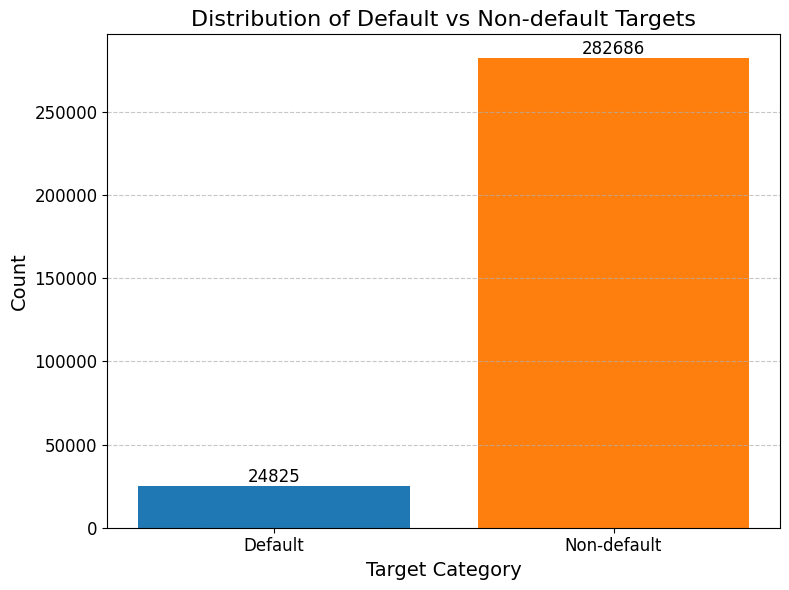

df_numeric shape: (307511, 106)
Correlation matrix shape: (106, 106)

=== Potentially highly correlated columns ===
['AMT_GOODS_PRICE', 'FLAG_EMP_PHONE', 'REGION_RATING_CLIENT_W_CITY', 'LIVINGAPARTMENTS_AVG', 'LIVINGAREA_AVG', 'APARTMENTS_MODE', 'BASEMENTAREA_MODE', 'YEARS_BEGINEXPLUATATION_MODE', 'YEARS_BUILD_MODE', 'COMMONAREA_MODE', 'ELEVATORS_MODE', 'ENTRANCES_MODE', 'FLOORSMAX_MODE', 'FLOORSMIN_MODE', 'LANDAREA_MODE', 'LIVINGAPARTMENTS_MODE', 'LIVINGAREA_MODE', 'NONLIVINGAPARTMENTS_MODE', 'NONLIVINGAREA_MODE', 'APARTMENTS_MEDI', 'BASEMENTAREA_MEDI', 'YEARS_BEGINEXPLUATATION_MEDI', 'YEARS_BUILD_MEDI', 'COMMONAREA_MEDI', 'ELEVATORS_MEDI', 'ENTRANCES_MEDI', 'FLOORSMAX_MEDI', 'FLOORSMIN_MEDI', 'LANDAREA_MEDI', 'LIVINGAPARTMENTS_MEDI', 'LIVINGAREA_MEDI', 'NONLIVINGAPARTMENTS_MEDI', 'NONLIVINGAREA_MEDI', 'TOTALAREA_MODE', 'OBS_60_CNT_SOCIAL_CIRCLE']
Count: 35

Overlap columns with numeric correlation matrix: ['AMT_GOODS_PRICE', 'FLAG_EMP_PHONE', 'REGION_RATING_CLIENT_W_CITY', 'LIVINGAPA

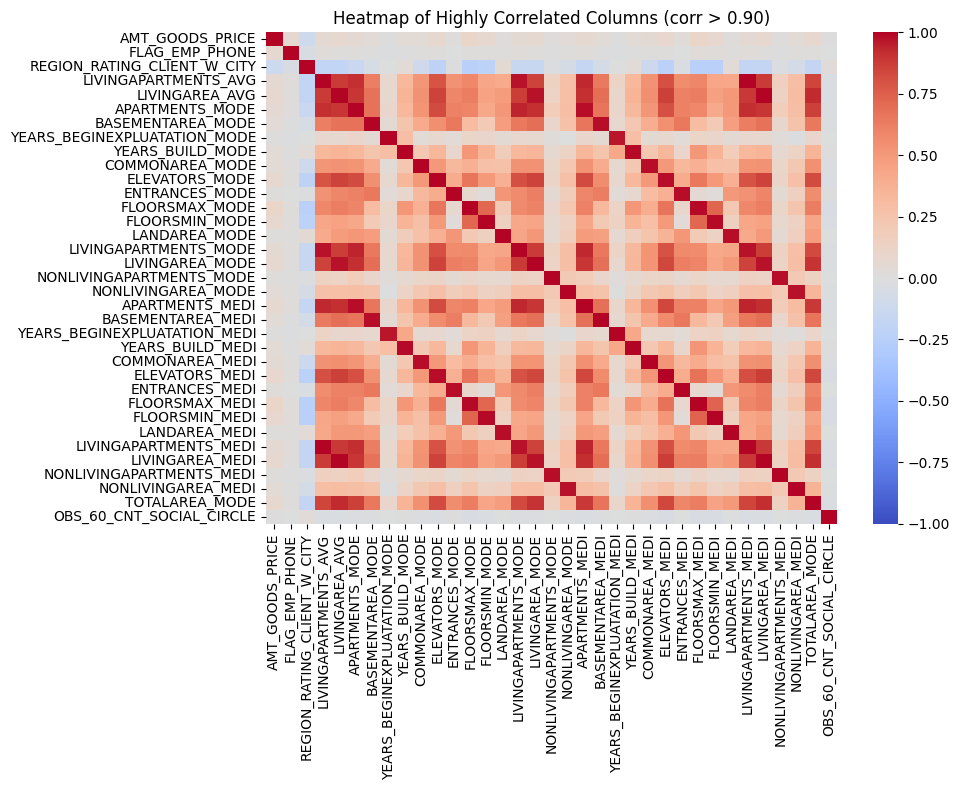

In [6]:
############################################################
# Graphs
############################################################

# Count the targets before cleaning
target_counts = df_full['TARGET'].value_counts()

# Plot the data
labels = ['Default', 'Non-default']
counts = [target_counts.get(1, 0), target_counts.get(0, 0)]

# Create the plot
fig, ax = plt.subplots(figsize=(8, 6))

# Bar chart with professional colors (blue and orange)
bars = ax.bar(labels, counts, color=['#1f77b4', '#ff7f0e'])

# Add labels and title
ax.set_xlabel('Target Category', fontsize=14)
ax.set_ylabel('Count', fontsize=14)
ax.set_title('Distribution of Default vs Non-default Targets', fontsize=16)
ax.tick_params(axis='both', labelsize=12)

# Add gridlines for better readability
ax.grid(True, axis='y', linestyle='--', alpha=0.7)

# Add number labels on top of each bar
for bar in bars:
    yval = bar.get_height()
    ax.text(bar.get_x() + bar.get_width() / 2, yval, int(yval), ha='center', va='bottom', fontsize=12)

# Show the plot
plt.tight_layout()
plt.show()


import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

#######################
# 1. READ IN DATA
#######################
# Suppose you have a DataFrame df with many columns (both numeric and categorical).
# For demonstration, we assume df is already loaded, e.g.:
# df = pd.read_csv('application_train.csv')

# If you haven't loaded df, uncomment the following and adjust the path:
# df = pd.read_csv('application_train.csv')

#######################
# 2. SELECT NUMERIC COLUMNS ONLY
#######################
df_numeric = df_full.select_dtypes(include=[np.number]).copy()
print("df_numeric shape:", df_numeric.shape)

# Optionally, fill or drop missing data if needed
# e.g. df_numeric.dropna(axis=0, how='any', inplace=True)  # or an imputation strategy

#######################
# 3. COMPUTE CORRELATION MATRIX
#######################
corr_matrix = df_numeric.corr()
print("Correlation matrix shape:", corr_matrix.shape)

#######################
# 4. BUILD UPPER TRIANGLE & THRESHOLD
#######################
# We'll isolate the upper triangle to avoid double-counting symmetrical pairs
upper_tri = corr_matrix.where(
    np.triu(np.ones(corr_matrix.shape), k=1).astype(bool)
)

threshold = 0.90

# Identify columns that have correlation > threshold with at least one other
to_drop = [
    col for col in upper_tri.columns
    if any(upper_tri[col].abs() > threshold)
]

print("\n=== Potentially highly correlated columns ===")
print(to_drop)
print("Count:", len(to_drop))

#######################
# 5. CHECK OVERLAP WITH CORR_MATRIX
#######################
# Some columns in 'to_drop' might not exist or might have been removed,
# or might be categorical in the original data. We'll verify overlap.
overlap_cols = [col for col in to_drop if col in corr_matrix.columns]
print("\nOverlap columns with numeric correlation matrix:", overlap_cols)

if not overlap_cols:
    print("No overlap. The columns in to_drop do not appear (or remain) in corr_matrix.")
else:
    #######################
    # 6. SUBSET CORRELATION FOR JUST THOSE 'to_drop' COLUMNS
    #######################
    sub_corr = corr_matrix.loc[overlap_cols, overlap_cols]
    print("sub_corr shape:", sub_corr.shape)

    if sub_corr.shape[0] == 0 or sub_corr.shape[1] == 0:
        print("sub_corr is empty, so no heatmap to display.")
    else:
        #######################
        # 7. PLOT HEATMAP
        #######################
        plt.figure(figsize=(10,8))
        sns.heatmap(sub_corr, annot=False, cmap='coolwarm', vmin=-1, vmax=1)
        plt.title("Heatmap of Highly Correlated Columns (corr > 0.90)")
        plt.tight_layout()
        plt.show()